In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [104]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


In [110]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print len(df)
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
3184496,337,PASSA QUATRO,1017.0,-22.395799,-44.961909,A529,Passa Quatro,MG,2007-12-02 08:00:00,2007-12-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1620525,319,TIMÓTEO,493.0,-19.573824,-42.622413,A511,Timóteo,MG,2009-12-07 21:00:00,2009-12-07,...,26.4,20.9,25.5,19.7,70.0,74.0,67.0,1.6,85.0,3.1
4999317,359,RIO PARDO DE MINAS,850.0,-15.723139,-42.435750,A551,Rio Pardo de Minas,MG,2011-12-09 13:00:00,2011-12-09,...,23.9,19.5,22.3,18.4,74.0,79.0,74.0,3.7,11.0,7.6


In [6]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [7]:
df.sample(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
1117252,339,MARIA DA FÉ,1281.0,-22.314567,-45.373049,A531,Maria da Fé,MG,2011-12-27 04:00:00,2011-12-27,...,15.3,14.8,15.0,14.5,97.0,97.0,97.0,NaN,149.0,1.1
2104953,379,PICO DO COUTO,1758.0,-22.464889,-43.291505,A610,Petrópolis,RJ,2013-02-15 09:00:00,2013-02-15,...,16.6,14.9,15.7,14.3,94.0,94.0,87.0,0.0,0.0,0.0
995002,335,TEÓFILO OTONI,467.0,-17.892840,-41.515423,A527,Teófilo Otoni,MG,2008-12-26 10:00:00,2008-12-26,...,22.8,20.6,20.9,19.7,85.0,94.0,85.0,1.1,67.0,1.7
3063211,417,BARRA BONITA,534.0,-22.471205,-48.557573,A741,Barra Bonita,SP,2010-02-20 19:00:00,2010-02-20,...,30.4,20.7,29.4,19.5,54.0,58.0,53.0,2.6,110.0,4.2


# Pré-processamento

<h3>Dados ausentes</h3>

In [8]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [9]:
missing_values_count[missing_values_count > 0.1]

prcp    81.451521
gbrd    41.773469
wdsp     9.086096
gust     2.863085
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [10]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [11]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [12]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [13]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

tmax    0.000468
dewp    0.000499
dmin    0.000592
hmin    0.000873
dtype: float64

<p>Alguns campos estão com pouquissimos valores nulos.</p>

In [15]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [16]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

In [17]:
cols_with_missing = list((col for col in df[V].columns 
                                 if df[col].isnull().any()))

In [18]:
for col in cols_with_missing:
    df[col + '_was_missing'] = df[col].isnull()

In [20]:
NEW = ['tmax_was_missing', 'dewp_was_missing','dmin_was_missing', 'hmin_was_missing']

<p>Listando alguns exemplos com dados ausentes</p>

In [23]:
x = df[(df['tmax_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
534891,0.0,957.0,957.4,957.0,22.4,NaN,22.7,1.6,22.4,NaN,23.0,25.0,23.0,0.0,0.0,0.0
2255000,0.0,895.0,895.0,894.6,10.3,NaN,10.8,0.4,10.2,-0.3,49.0,49.0,48.0,0.3,330.0,0.5
2255019,0.0,896.6,897.3,896.6,15.3,NaN,15.9,0.8,14.9,-1.0,35.0,36.0,33.0,0.6,291.0,1.8
2255570,0.0,897.2,897.4,897.2,20.4,NaN,21.6,1.1,20.4,-0.2,26.0,27.0,24.0,2.9,70.0,6.1
2255571,0.0,897.0,897.2,897.0,20.6,NaN,20.8,0.3,20.0,-0.8,25.0,26.0,25.0,3.2,59.0,6.0
2549620,0.0,1013.0,1013.6,1013.0,21.4,NaN,21.5,NaN,21.1,-0.7,24.0,24.0,23.0,0.0,77.0,1.8
2549624,0.0,1012.7,1012.7,1012.2,19.9,NaN,20.0,NaN,19.8,-0.5,26.0,26.0,26.0,0.0,79.0,0.3
2820887,0.0,955.1,955.1,954.5,25.1,NaN,26.3,NaN,25.1,0.0,19.0,19.0,0.0,1.3,158.0,5.7
2820981,5.0,954.5,954.5,954.0,25.6,NaN,27.9,0.3,23.6,0.0,19.0,20.0,0.0,0.9,325.0,9.0
2914423,0.0,961.8,961.9,961.6,21.4,NaN,21.7,4.8,20.9,-0.1,24.0,34.0,24.0,1.4,81.0,1.8


In [76]:
NEW

['tmax_was_missing',
 'dewp_was_missing',
 'dmin_was_missing',
 'hmin_was_missing']

<p>Para <b>temperatura máxima</b> vou preencher o valor com o valor da temp da instância, visto que são pouquissímos casos</p>

In [79]:
x = df.groupby(['wsid']).tmax_was_missing.apply(lambda g: (g == True).sum())
x[x > 0]

wsid
319    1
385    4
398    2
408    2
411    6
Name: tmax_was_missing, dtype: int64

In [82]:
df['tmax'] = df['tmax'].fillna(df['temp'])

In [85]:
x = df[(df['tmax_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
534891,0.0,957.0,957.4,957.0,22.4,22.4,22.7,1.6,22.4,NaN,23.0,25.0,23.0,0.0,0.0,0.0
2255000,0.0,895.0,895.0,894.6,10.3,10.3,10.8,0.4,10.2,-0.3,49.0,49.0,48.0,0.3,330.0,0.5
2255019,0.0,896.6,897.3,896.6,15.3,15.3,15.9,0.8,14.9,-1.0,35.0,36.0,33.0,0.6,291.0,1.8
2255570,0.0,897.2,897.4,897.2,20.4,20.4,21.6,1.1,20.4,-0.2,26.0,27.0,24.0,2.9,70.0,6.1
2255571,0.0,897.0,897.2,897.0,20.6,20.6,20.8,0.3,20.0,-0.8,25.0,26.0,25.0,3.2,59.0,6.0
2549620,0.0,1013.0,1013.6,1013.0,21.4,21.4,21.5,NaN,21.1,-0.7,24.0,24.0,23.0,0.0,77.0,1.8
2549624,0.0,1012.7,1012.7,1012.2,19.9,19.9,20.0,NaN,19.8,-0.5,26.0,26.0,26.0,0.0,79.0,0.3
2820887,0.0,955.1,955.1,954.5,25.1,25.1,26.3,NaN,25.1,0.0,19.0,19.0,0.0,1.3,158.0,5.7
2820981,5.0,954.5,954.5,954.0,25.6,25.6,27.9,0.3,23.6,0.0,19.0,20.0,0.0,0.9,325.0,9.0
2914423,0.0,961.8,961.9,961.6,21.4,21.4,21.7,4.8,20.9,-0.1,24.0,34.0,24.0,1.4,81.0,1.8


<p>Para <b>ponto de orvalho</b> vou preencher o valor com o valor da temperatura do ponto de orvalho minima da instância, visto que são pouquissímos casos</p>

In [91]:
x = df.groupby(['wsid']).dewp_was_missing.apply(lambda g: (g == True).sum())
x[x > 0]

wsid
319    1
372    1
385    1
398    3
408    6
411    1
418    3
Name: dewp_was_missing, dtype: int64

In [88]:
df['dewp'] = df['dewp'].fillna(df['dmin'])

In [89]:
x = df[(df['dewp_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
534869,0.0,956.7,956.7,956.3,20.4,-1.0,21.5,-1.3,20.1,-1.3,24.0,24.0,24.0,0.0,0.0,0.0
1874270,0.0,1011.5,1011.8,1011.5,28.0,0.0,28.2,0.0,25.8,0.0,0.0,17.0,0.0,4.7,124.0,6.5
2255020,0.2,896.3,896.6,896.2,14.4,-0.9,15.3,-1.6,14.2,-1.6,35.0,35.0,33.0,0.4,34.0,1.3
2549620,0.0,1013.0,1013.6,1013.0,21.4,21.4,21.5,-0.7,21.1,-0.7,24.0,24.0,23.0,0.0,77.0,1.8
2549621,1.2,1012.7,1013.0,1012.6,21.3,-0.4,21.4,-0.4,21.2,-0.4,24.0,24.0,24.0,0.0,78.0,1.8
2549624,0.0,1012.7,1012.7,1012.2,19.9,19.9,20.0,-0.5,19.8,-0.5,26.0,26.0,26.0,0.0,79.0,0.3
2820673,0.2,957.7,957.7,956.9,22.4,0.0,22.4,0.0,22.2,0.0,0.0,23.0,0.0,0.0,129.0,1.8
2820885,0.0,953.7,953.8,953.6,27.9,-0.6,28.0,0.0,27.0,0.0,16.0,17.0,0.0,0.0,273.0,4.0
2820887,0.0,955.1,955.1,954.5,25.1,25.1,26.3,0.0,25.1,0.0,19.0,19.0,0.0,1.3,158.0,5.7
2820894,0.0,955.9,956.2,955.9,22.4,-1.8,23.3,-2.5,22.3,-2.5,20.0,21.0,19.0,0.7,28.0,2.1


<p>Para <b>ponto de orvalho MINIMO</b> vou preencher o valor com o valor da temperatura do ponto de orvalho minima da instância, visto que são pouquissímos casos</p>

In [92]:
x = df.groupby(['wsid']).dmin_was_missing.apply(lambda g: (g == True).sum())
x[x > 0]

wsid
319    2
358    1
379    1
385    3
408    2
411    7
417    1
418    2
Name: dmin_was_missing, dtype: int64

In [94]:
df['dmin'] = df['dmin'].fillna(df['dewp'])

In [95]:
x = df[(df['dmin_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
534865,0.0,957.5,957.5,957.1,21.3,0.1,21.6,0.5,21.1,0.5,24.0,25.0,24.0,0.0,0.0,0.0
534891,0.0,957.0,957.4,957.0,22.4,22.4,22.7,1.6,22.4,1.6,23.0,25.0,23.0,0.0,0.0,0.0
1618218,0.0,978.4,979.3,978.4,35.7,8.6,36.4,9.0,35.4,9.0,19.0,19.0,10.0,1.9,60.0,5.0
2100700,0.0,825.3,825.9,825.3,15.1,0.8,15.1,1.4,14.7,1.4,38.0,40.0,36.0,4.4,76.0,7.9
2255016,0.0,897.5,897.5,896.7,15.9,0.4,17.6,1.4,15.9,1.4,35.0,35.0,33.0,0.5,322.0,4.6
2255561,0.0,896.3,896.8,896.3,24.3,1.7,25.4,3.3,24.1,3.3,23.0,25.0,20.0,3.7,69.0,9.2
2255566,0.0,895.7,895.7,895.3,22.4,1.5,23.3,1.5,22.1,1.5,25.0,25.0,22.0,2.8,37.0,7.7
2820891,0.0,957.2,957.2,956.8,24.1,0.2,24.6,1.3,24.1,1.3,21.0,22.0,20.0,1.2,8.0,2.6
2820920,0.0,956.6,956.7,956.5,23.3,1.8,23.4,1.8,23.1,1.8,24.0,24.0,21.0,1.1,340.0,4.3
2919702,0.0,965.5,965.7,965.5,22.0,0.1,22.1,3.9,21.6,3.9,23.0,31.0,23.0,0.7,24.0,1.8


<p>Para <b>humidade MINIMA</b> vou preencher o valor com o valor da humidade da instância, visto que são pouquissímos casos</p>

In [97]:
x = df.groupby(['wsid']).hmin_was_missing.apply(lambda g: (g == True).sum())
x[x > 0]

wsid
372    28
Name: hmin_was_missing, dtype: int64

In [98]:
df['hmin'] = df['hmin'].fillna(df['hmdy'])

In [99]:
x = df[(df['hmin_was_missing'] == True)]
x[V]

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
1851676,0.2,1007.2,1008.0,1007.2,22.6,-7.0,22.9,20.5,22.5,0.0,0.0,87.0,0.0,3.3,315.0,6.5
1851677,0.4,1006.8,1007.2,1006.8,21.6,-4.9,22.7,11.7,21.6,0.0,0.0,55.0,0.0,3.0,330.0,6.4
1851678,0.8,1006.5,1006.9,1006.5,20.8,0.0,21.7,14.1,20.8,0.0,0.0,65.0,0.0,2.7,331.0,4.3
1851679,1.0,1005.7,1006.6,1005.7,20.9,0.0,21.0,0.0,20.4,0.0,0.0,21.0,0.0,3.2,18.0,5.5
1851680,1.6,1005.5,1005.9,1005.5,20.9,0.0,21.0,0.0,20.4,0.0,0.0,11.0,0.0,4.5,8.0,7.8
1851681,2.0,1005.4,1005.6,1005.3,20.6,0.0,21.0,0.0,20.3,0.0,0.0,20.0,0.0,2.0,23.0,5.0
1851682,0.2,1005.0,1005.4,1004.9,21.2,0.0,21.2,13.4,20.0,0.0,0.0,67.0,0.0,3.3,360.0,5.7
1851683,0.0,1005.6,1005.6,1004.9,22.1,0.0,22.5,0.0,21.1,0.0,0.0,2.0,0.0,2.5,344.0,7.8
1851684,0.2,1006.0,1006.1,1005.5,21.9,0.0,22.6,0.0,21.9,0.0,0.0,11.0,0.0,2.9,320.0,6.7
1851685,0.2,1005.5,1006.0,1005.2,22.9,0.0,22.9,0.0,21.7,0.0,0.0,34.0,0.0,5.4,338.0,7.9


In [102]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [27]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['wsid',
 'wsnm',
 'elvt',
 'lat',
 'lon',
 'inme',
 'city',
 'prov',
 'mdct',
 'date',
 'yr',
 'mo',
 'da',
 'hr',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [28]:
df[cols] = df[cols].replace({0.0:np.nan})

In [29]:
print len(df)
df  = df.dropna()
print len(df)

2715364
2715364


<p>Verificando os mínimos e máximos por região.</p>

In [79]:
#xx = df [df['wsid'] != 372] 

In [19]:
for r in ['ES','RJ','SP','MG']:
    x = df[df['prov'] == r]
    print 'Estado %s' % r 
    print x[V].describe().T

Estado ES
         count        mean         std    min    25%     50%     75%     max
prcp  211492.0    0.203312    1.420546    0.0    0.0     0.0     0.0    96.8
stp   211492.0  991.357867   33.810547  894.3  995.5  1005.3  1010.3  1020.8
smax  211492.0  991.611915   33.818914  895.0  995.8  1005.6  1010.6  1020.9
smin  211492.0  991.128599   33.802889  894.2  995.3  1005.1  1010.1  1020.6
temp  211492.0   25.589549    4.016106   13.4   22.9    25.0    28.4    43.5
tmax  211492.0   20.491767    2.037271    5.3   19.3    20.8    21.9    35.0
tmin  211492.0   26.234340    4.241372   13.6   23.3    25.6    29.3    45.0
dewp  211492.0   21.032350    1.949572    8.9   19.9    21.3    22.4    35.7
dmax  211492.0   24.979169    3.796445   13.2   22.5    24.5    27.5    42.3
dmin  211492.0   19.976240    2.144806    3.6   18.6    20.3    21.5    33.6
hmdy  211492.0   75.916867   17.120956   13.0   63.0    80.0    91.0   100.0
hmax  211492.0   78.720032   15.929572   15.0   67.0    83.0    92

In [ ]:
#Zarate pediu para fazer um boxspot com 3 desvios padrão, e ver os outliers. Removê-los.

<p>Temos algumas temperaturas negativas que pode ser inválidas.</p>

In [85]:
CON = ['tmax_was_missing', 'dewp_was_missing','dmin_was_missing', 'hmin_was_missing']

In [ ]:
x = df[(df['prov'] == 'RJ') & (df['tmax'] < 0) & (df[CON] ==True) ]
print x[ ['wsnm','mdct'] + V + CON]

In [ ]:
x

<h3>Derivando novas variáveis</h3>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [117]:
dfm = df

In [118]:
len(dfm)

83784

In [119]:
#dfm.index = pd.to_datetime(dfm.mdct)
#dfm = dfm.set_index(['mdct','wsid']).unstack().swaplevel(0,1,1).sort_index(1)
#dfm.head(4)

In [120]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,20.7,20.5,20.4,20.2,99.0,99.0,98.0,1.0,121.0,2.6
1,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,20.9,20.6,20.7,20.5,98.0,99.0,98.0,1.2,146.0,2.0
2,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,20.9,20.6,20.5,20.3,98.0,98.0,98.0,0.5,309.0,2.0
3,329,854.0,-19.883945,-43.969397,2006-12-01 03:00:00,1.8,915.1,916.0,915.1,20.7,...,20.7,20.5,20.6,20.3,98.0,98.0,98.0,0.0,356.0,0.9
4,329,854.0,-19.883945,-43.969397,2006-12-01 04:00:00,12.4,914.4,915.2,914.4,20.4,...,20.7,20.4,20.4,20.1,98.0,98.0,98.0,2.3,83.0,3.8


In [121]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print ws

[329, 343, 363, 370]


In [122]:
#dfm = dfm[dfm['wsid'].isin([178, 329])]
#len(dfm)

In [31]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [32]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,6,NON_DER)

In [33]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [34]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [35]:
#ws = [178,329]
#for w in ws:
#    for k,v in cols.items():
#        idx = dfr.loc[dfr['wsid']==w].index
#        dfr.loc[dfr.loc[idx,v].index[int(k)],k] = np.nan

In [73]:
xxx = dfr.copy()

In [74]:
#Acumulando 6 ultimos dias de precipitação
xxx['prcp_acum_6'] = 99.0
xxx['prcp_plus_1'] = 99.0

In [75]:
xxx.head(3)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6,prcp_acum_6,prcp_plus_1
0,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,99.0
1,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,99.0,99.0
2,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,99.0,99.0


In [76]:
pos_acum_6 = xxx.columns.get_loc('prcp_acum_6')
print pos_acum_6
xxx.iloc[0,pos_acum_6] = xxx.loc[xxx['wsid'].isin([329])].iloc[0:0+6,pos_prcp].sum()
xxx.iloc[0,pos_acum_6]

123


15.200000000000001

In [108]:
for w in ws:
    
    size = xxx.loc[xxx['wsid'].isin([w])].iloc[:]['prcp'].count()
    
    pos_prcp = xxx.columns.get_loc('prcp')
    
    pos_acum_6 = xxx.columns.get_loc('prcp_acum_6')
    pos_plus_1 = xxx.columns.get_loc('prcp_plus_1')
    
    for i in range(0,size):
        idx = xxx.loc[xxx['wsid'].isin([w])].index
        xxx.loc[xxx.loc[idx,'prcp_acum_6'].index[i],'prcp_acum_6'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+6,pos_prcp].sum()
        if i+1 < size:
            xxx.loc[xxx.loc[idx,'prcp_plus_1'].index[i],'prcp_plus_1'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i+1,pos_prcp]
        else:
            xxx.loc[xxx.loc[idx,'prcp_plus_1'].index[i],'prcp_plus_1'] = 99.99

In [119]:
#dfr = xxx 
#dfr.to_csv('../data/bh-calculado.csv',index=False)

In [8]:
dfr = pd.read_csv('../data/bh-calculado.csv')
dfr.head(4)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_5,dmax_6,prcp_1,prcp_2,prcp_3,prcp_4,prcp_5,prcp_6,prcp_acum_6,prcp_plus_1
0,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,0.0
1,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,15.2,0.4
2,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,15.2,1.8
3,329,854.0,-19.883945,-43.969397,2006-12-01 03:00:00,1.8,915.1,916.0,915.1,20.7,...,NaN,NaN,0.4,0.0,0.0,NaN,NaN,NaN,14.8,12.4


In [41]:
len(dfr)

83784

In [42]:
for w in ws:
    x = dfr.loc[dfr['wsid'].isin([w])].iloc[0:6].index
    dfr.drop(dfr.index[x], inplace=True)

In [43]:
#x = dfr.loc[dfr['wsid'].isin([329])].iloc[0:6].index
#dfr.drop(dfr.index[x],  inplace=True)
#dfr.drop(x)
#dfr.loc[x]

In [44]:
dfm = dfr

In [45]:
REMOVE = [u'prcp',u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5', u'prcp_6']
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

In [46]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdsp',
 'wdct',
 'gust',
 'wdct_1',
 'wdct_2',
 'wdct_3',
 'wdct_4',
 'wdct_5',
 'wdct_6',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'hmax_1',
 'hmax_2',
 'hmax_3',
 'hmax_4',
 'hmax_5',
 'hmax_6',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'hmin_1',
 'hmin_2',
 'hmin_3',
 'hmin_4',
 'hmin_5',
 'hmin_6',
 'gust_1',
 'gust_2',
 'gust_3',
 'gust_4',
 'gust_5',
 'gust_6',
 'tmax_1',
 'tmax_2',
 'tmax_3',
 'tmax_4',
 'tmax_5',
 'tmax_6',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'hmdy_1',
 'hmdy_2',
 'hmdy_3',
 'hmdy_4',
 'hmdy_5',
 'hmdy_6',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 'mdct_5',
 'mdct_6',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 'dewp_5',
 'dewp_6',
 'wdsp_1',
 'wdsp_2',
 'wdsp_3',
 'wdsp_4',
 'wdsp_5',
 'wdsp_6',
 'stp_1',
 'stp_2',
 'stp_3',
 

In [47]:
len(dfm)

83760

In [48]:
dfm = dfm.dropna()  

In [49]:
len(dfm)

83760

In [50]:
dfm = dfm.reset_index(drop=True)

In [51]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,stp,smax,smin,temp,tmax,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_acum_6,prcp_plus_1
0,329,854.0,-19.883945,-43.969397,2006-12-01 06:00:00,913.5,913.8,913.4,20.8,19.0,...,20.5,20.2,20.2,20.4,20.6,20.5,20.7,20.4,0.0,0.0
1,329,854.0,-19.883945,-43.969397,2006-12-01 07:00:00,913.4,913.6,913.4,20.2,19.3,...,20.3,20.5,20.1,20.2,20.4,20.6,20.5,20.7,0.0,0.0
2,329,854.0,-19.883945,-43.969397,2006-12-01 08:00:00,914.2,914.2,913.4,20.1,19.4,...,20.3,20.3,20.2,20.1,20.2,20.4,20.6,20.5,0.2,0.0
3,329,854.0,-19.883945,-43.969397,2006-12-01 09:00:00,915.0,915.0,914.2,20.7,19.4,...,20.1,20.3,19.9,20.2,20.1,20.2,20.4,20.6,0.2,0.0
4,329,854.0,-19.883945,-43.969397,2006-12-01 10:00:00,915.7,915.7,915.0,21.3,19.3,...,19.5,20.1,19.9,19.9,20.2,20.1,20.2,20.4,0.6,0.0


In [52]:
#como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [53]:
x = dfm[dfm['wsid'].isin([329])]
x.head(4)

,wsid,mdct,stp,smax,smin,temp,tmax,tmin,dewp,dmax,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_acum_6,prcp_plus_1
0,329,2006-12-01 06:00:00,913.5,913.8,913.4,20.8,19.0,21.0,19.6,20.1,...,20.5,20.2,20.2,20.4,20.6,20.5,20.7,20.4,0.0,0.0
1,329,2006-12-01 07:00:00,913.4,913.6,913.4,20.2,19.3,20.8,19.7,20.2,...,20.3,20.5,20.1,20.2,20.4,20.6,20.5,20.7,0.0,0.0
2,329,2006-12-01 08:00:00,914.2,914.2,913.4,20.1,19.4,20.6,19.4,19.9,...,20.3,20.3,20.2,20.1,20.2,20.4,20.6,20.5,0.2,0.0
3,329,2006-12-01 09:00:00,915.0,915.0,914.2,20.7,19.4,20.7,19.5,19.9,...,20.1,20.3,19.9,20.2,20.1,20.2,20.4,20.6,0.2,0.0


In [54]:
dfm.head(5)

,wsid,mdct,stp,smax,smin,temp,tmax,tmin,dewp,dmax,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_acum_6,prcp_plus_1
0,329,2006-12-01 06:00:00,913.5,913.8,913.4,20.8,19.0,21.0,19.6,20.1,...,20.5,20.2,20.2,20.4,20.6,20.5,20.7,20.4,0.0,0.0
1,329,2006-12-01 07:00:00,913.4,913.6,913.4,20.2,19.3,20.8,19.7,20.2,...,20.3,20.5,20.1,20.2,20.4,20.6,20.5,20.7,0.0,0.0
2,329,2006-12-01 08:00:00,914.2,914.2,913.4,20.1,19.4,20.6,19.4,19.9,...,20.3,20.3,20.2,20.1,20.2,20.4,20.6,20.5,0.2,0.0
3,329,2006-12-01 09:00:00,915.0,915.0,914.2,20.7,19.4,20.7,19.5,19.9,...,20.1,20.3,19.9,20.2,20.1,20.2,20.4,20.6,0.2,0.0
4,329,2006-12-01 10:00:00,915.7,915.7,915.0,21.3,19.3,21.3,19.3,20.6,...,19.5,20.1,19.9,19.9,20.2,20.1,20.2,20.4,0.6,0.0


In [55]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [56]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5','wdsp_6' \
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5','gust_6', 'prcp_acum_6','prcp_plus_1']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)

In [57]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(10)

,wsid,mdct,stp,smax,smin,temp,tmax,tmin,dewp,dmax,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_acum_6,prcp_plus_1
0,329,2006-12-01 06:00:00,913.5,913.8,913.4,20.8,19.0,21.0,19.6,20.1,...,20.5,20.2,20.2,20.4,20.6,20.5,20.7,20.4,0.0,0.0
1,329,2006-12-01 07:00:00,913.4,913.6,913.4,20.2,19.3,20.8,19.7,20.2,...,20.3,20.5,20.1,20.2,20.4,20.6,20.5,20.7,0.0,0.0
2,329,2006-12-01 08:00:00,914.2,914.2,913.4,20.1,19.4,20.6,19.4,19.9,...,20.3,20.3,20.2,20.1,20.2,20.4,20.6,20.5,0.2,0.0
3,329,2006-12-01 09:00:00,915.0,915.0,914.2,20.7,19.4,20.7,19.5,19.9,...,20.1,20.3,19.9,20.2,20.1,20.2,20.4,20.6,0.2,0.0
4,329,2006-12-01 10:00:00,915.7,915.7,915.0,21.3,19.3,21.3,19.3,20.6,...,19.5,20.1,19.9,19.9,20.2,20.1,20.2,20.4,0.6,0.0
5,329,2006-12-01 11:00:00,916.2,916.3,915.7,21.9,19.1,21.9,19.6,21.2,...,19.0,19.5,20.6,19.9,19.9,20.2,20.1,20.2,0.6,0.0
6,329,2006-12-01 12:00:00,916.7,916.7,916.2,22.9,18.9,23.0,19.5,21.9,...,19.1,19.0,21.2,20.6,19.9,19.9,20.2,20.1,0.6,0.2
7,329,2006-12-01 13:00:00,916.9,916.9,916.7,22.2,19.0,23.2,19.5,22.2,...,19.1,19.1,21.9,21.2,20.6,19.9,19.9,20.2,0.6,0.0
8,329,2006-12-01 14:00:00,916.9,917.0,916.9,22.9,18.7,23.0,19.7,21.8,...,19.2,19.1,22.2,21.9,21.2,20.6,19.9,19.9,0.4,0.4
9,329,2006-12-01 15:00:00,916.9,917.1,916.9,22.6,18.4,23.1,19.9,22.1,...,18.8,19.2,21.8,22.2,21.9,21.2,20.6,19.9,0.4,0.0


In [58]:
len(dfm)

83760

In [59]:
dfm = dfm.dropna()

In [60]:
len(dfm)

67144

In [61]:
dfm.head(5)

,wsid,mdct,stp,smax,smin,temp,tmax,tmin,dewp,dmax,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_acum_6,prcp_plus_1
0,329,2006-12-01 06:00:00,913.5,913.8,913.4,20.8,19.0,21.0,19.6,20.1,...,20.5,20.2,20.2,20.4,20.6,20.5,20.7,20.4,0.0,0.0
1,329,2006-12-01 07:00:00,913.4,913.6,913.4,20.2,19.3,20.8,19.7,20.2,...,20.3,20.5,20.1,20.2,20.4,20.6,20.5,20.7,0.0,0.0
2,329,2006-12-01 08:00:00,914.2,914.2,913.4,20.1,19.4,20.6,19.4,19.9,...,20.3,20.3,20.2,20.1,20.2,20.4,20.6,20.5,0.2,0.0
4,329,2006-12-01 10:00:00,915.7,915.7,915.0,21.3,19.3,21.3,19.3,20.6,...,19.5,20.1,19.9,19.9,20.2,20.1,20.2,20.4,0.6,0.0
5,329,2006-12-01 11:00:00,916.2,916.3,915.7,21.9,19.1,21.9,19.6,21.2,...,19.0,19.5,20.6,19.9,19.9,20.2,20.1,20.2,0.6,0.0


In [62]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67144 entries, 0 to 83759
Columns: 115 entries, wsid to prcp_plus_1
dtypes: float64(107), int64(1), object(7)
memory usage: 59.4+ MB


In [63]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [64]:
dfm.head(4)

,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,...,dmin_5,dmin_6,dmax_1,dmax_2,dmax_3,dmax_4,dmax_5,dmax_6,prcp_acum_6,prcp_plus_1
0,913.5,913.8,913.4,20.8,19.0,21.0,19.6,20.1,19.0,90.0,...,20.5,20.2,20.2,20.4,20.6,20.5,20.7,20.4,0.0,0.0
1,913.4,913.6,913.4,20.2,19.3,20.8,19.7,20.2,19.1,95.0,...,20.3,20.5,20.1,20.2,20.4,20.6,20.5,20.7,0.0,0.0
2,914.2,914.2,913.4,20.1,19.4,20.6,19.4,19.9,19.1,96.0,...,20.3,20.3,20.2,20.1,20.2,20.4,20.6,20.5,0.2,0.0
4,915.7,915.7,915.0,21.3,19.3,21.3,19.3,20.6,18.8,88.0,...,19.5,20.1,19.9,19.9,20.2,20.1,20.2,20.4,0.6,0.0


In [65]:
REMOVE = [u'mdct',u'mdct_1', u'mdct_2', u'mdct_3', u'mdct_4', u'mdct_5', u'mdct_6']
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

In [66]:
dfm.columns

Index([u'stp', u'smax', u'smin', u'temp', u'tmax', u'tmin', u'dewp', u'dmax',
       u'dmin', u'hmdy',
       ...
       u'dmin_5', u'dmin_6', u'dmax_1', u'dmax_2', u'dmax_3', u'dmax_4',
       u'dmax_5', u'dmax_6', u'prcp_acum_6', u'prcp_plus_1'],
      dtype='object', length=107)

<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [67]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [68]:
target = 'prcp_plus_1'

In [69]:
X =  dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [70]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.1, random_state=12) 
print len(X_train)
print len(X_tmp)

60429
6715


<p>Separando o conjunto de testes</p>

In [71]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2)

In [72]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   60429, Training features   107
Validation instances 1343, Validation features 107
Testing instances    5372, Testing features    107


In [73]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [74]:
Z = X.copy()
Z.pop(target)
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [76]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      #,activation_fn=activation_fn
                                      ,model_dir='/tmp/tf_wx_model-24')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x116c9ef90>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_wx_model-24', '_save_summary_steps': 100}


In [77]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [78]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [79]:
def balancear(_X, _y):
    
    def f(x):
        if x['prcp_plus_1'] == 0.0: 
            return 0
        else:        
            return 1
        
    #Balancear considerando apenas com chuva e sem chuva.    
    _X['type'] = _X.apply(f,axis=1) 
    
    _X_resampled, _y_resampled, idx_resampled = under.fit_sample(_X, _X['type'])
    
    _X = pd.DataFrame(_X_resampled, columns = _X.columns)
    _y = pd.DataFrame(_y_resampled, columns =['type'])
    
    _y = _X['prcp_plus_1']
    
    _X = _X.drop('type',1)
    _X = _X.drop('prcp_plus_1',1)
    
    return _X,_y

In [80]:
#print len(X_train), len(y_train)

In [81]:
#A, b = balancear(X_train.copy(), y_train.copy())

In [82]:
#import collections, numpy
#collections.Counter(b)

In [83]:
#np.where(b==78.4)

In [84]:
#A.loc[8063:8063]

In [85]:
#xxx = X_train[X_train['prcp']==78.4]
#xxx

In [86]:
evaluations = []  
STEPS = 200  

for i in range(1, up):
    
    A, b = balancear(X_train.copy(), y_train.copy())
    
    print ('treinando agora...')
    
    regressor.train(
        input_fn=wx_input_fn(A
                            ,b)
        , steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(X_val
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 46287830.0, step = 1
INFO:tensorflow:global_step/sec: 7.18129
INFO:tensorflow:loss = 131624.34, step = 101 (13.927 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:Loss for final step: 76678.49.
INFO:tensorflow:Starting evaluation at 2018-03-23-00:03:07
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-200
INFO:tensorflow:Finished evaluation at 2018-03-23-00:03:09
INFO:tensorflow:Saving dict for global step 200: average_loss = 43.940613, global_step = 200, loss = 29506.121
treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-200
INFO:tensorflow:Saving checkpoints for 201 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 79719.59, step = 201
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 8.47677
INFO:tensorflow:loss = 3038.3228, step = 2101 (11.799 sec)
INFO:tensorflow:Saving checkpoints for 2200 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:Loss for final step: 3824.4565.
INFO:tensorflow:Starting evaluation at 2018-03-23-00:10:54
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-2200
INFO:tensorflow:Finished evaluation at 2018-03-23-00:10:56
INFO:tensorflow:Saving dict for global step 2200: average_loss = 6.285015, global_step = 2200, loss = 4220.3877
treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-2200
INFO:tensorflow:Saving checkpoints for 2201 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 2707.0283, step = 2201
INFO:tensorflow:global_step/sec: 3.23358
INFO:tensorflow:loss = 2487.5872, step = 2301 (30.927 sec)
INFO:tensorflow:Saving checkpoints for 2400 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflo

INFO:tensorflow:Loss for final step: 2167.6235.
INFO:tensorflow:Starting evaluation at 2018-03-23-00:19:35
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-4200
INFO:tensorflow:Finished evaluation at 2018-03-23-00:19:37
INFO:tensorflow:Saving dict for global step 4200: average_loss = 5.38525, global_step = 4200, loss = 3616.1953
treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-4200
INFO:tensorflow:Saving checkpoints for 4201 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 39500.48, step = 4201
INFO:tensorflow:global_step/sec: 8.82806
INFO:tensorflow:loss = 34172.645, step = 4301 (11.327 sec)
INFO:tensorflow:Saving checkpoints for 4400 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:Loss for final step: 28756.576.
INFO:tensorflow:Starting evaluation at 2018-03-23-00:20:16
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-4400
INFO:tensorf

INFO:tensorflow:Finished evaluation at 2018-03-23-00:28:52
INFO:tensorflow:Saving dict for global step 6200: average_loss = 8.6421995, global_step = 6200, loss = 5803.237
treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-6200
INFO:tensorflow:Saving checkpoints for 6201 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 7818.993, step = 6201
INFO:tensorflow:global_step/sec: 8.98543
INFO:tensorflow:loss = 7160.282, step = 6301 (11.131 sec)
INFO:tensorflow:Saving checkpoints for 6400 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:Loss for final step: 24124.0.
INFO:tensorflow:Starting evaluation at 2018-03-23-00:29:30
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-6400
INFO:tensorflow:Finished evaluation at 2018-03-23-00:29:32
INFO:tensorflow:Saving dict for global step 6400: average_loss = 6.603725, global_step = 6400, loss = 4434.4014
treinando agora...
INFO:tens

treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-8200
INFO:tensorflow:Saving checkpoints for 8201 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 1657.0818, step = 8201
INFO:tensorflow:global_step/sec: 8.80529
INFO:tensorflow:loss = 6715.95, step = 8301 (11.357 sec)
INFO:tensorflow:Saving checkpoints for 8400 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:Loss for final step: 12794.887.
INFO:tensorflow:Starting evaluation at 2018-03-23-00:36:49
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-8400
INFO:tensorflow:Finished evaluation at 2018-03-23-00:36:51
INFO:tensorflow:Saving dict for global step 8400: average_loss = 5.656814, global_step = 8400, loss = 3798.5505
treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-8400
INFO:tensorflow:Saving checkpoints for 8401 into /tmp/tf

INFO:tensorflow:Saving checkpoints for 10201 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 42602.363, step = 10201
INFO:tensorflow:global_step/sec: 4.77751
INFO:tensorflow:loss = 37807.82, step = 10301 (20.931 sec)
INFO:tensorflow:Saving checkpoints for 10400 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:Loss for final step: 35034.125.
INFO:tensorflow:Starting evaluation at 2018-03-23-00:45:04
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-10400
INFO:tensorflow:Finished evaluation at 2018-03-23-00:45:05
INFO:tensorflow:Saving dict for global step 10400: average_loss = 6.863807, global_step = 10400, loss = 4609.0464
treinando agora...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-10400
INFO:tensorflow:Saving checkpoints for 10401 into /tmp/tf_wx_model-24/model.ckpt.
INFO:tensorflow:loss = 53055.11, step = 10401
INFO:tensorflow:global_step/sec: 2.1726
INFO:tensorflow:loss

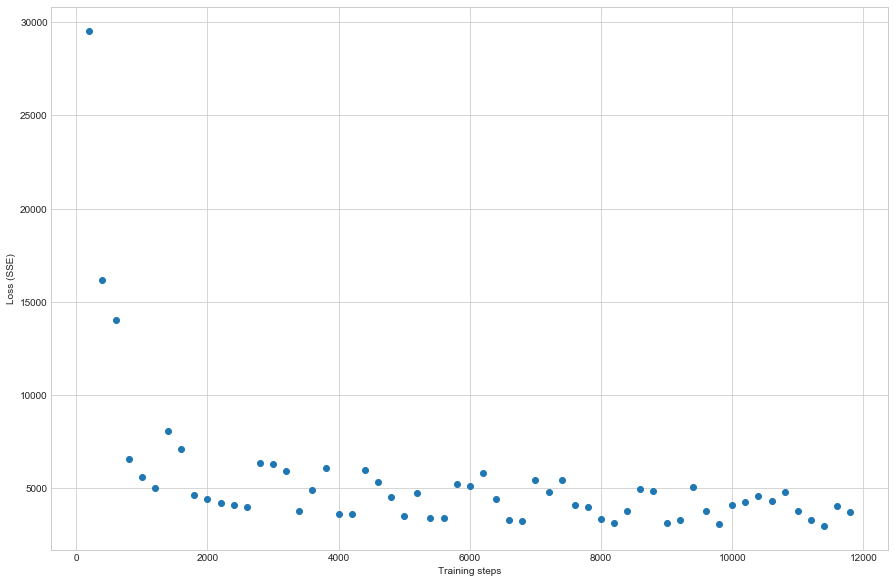

In [87]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [88]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-24/model.ckpt-11800


In [89]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f mm " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f mm" % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.15
The Mean Absolute Error: 1.51 mm 
The Median Absolute Error: 1.15 mm


In [90]:
predictions

array([ 1.0872155 ,  2.468937  , -0.08412543, ..., -1.9513587 ,
        1.6276437 ,  0.05587396], dtype=float32)

In [91]:
predictions.size

5372

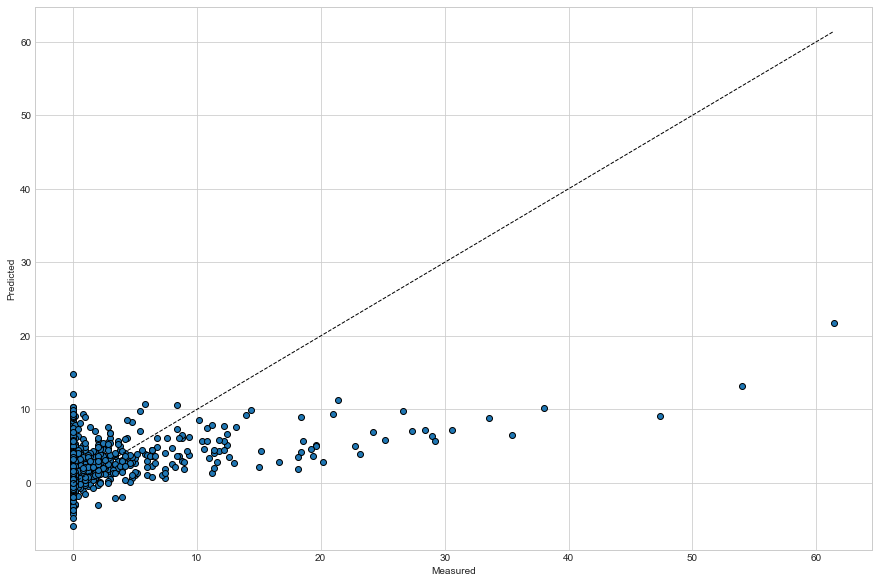

In [92]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()